# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-3.122581,False,-7.031578
1,-0.929257,True,3.592709
2,-1.290274,False,-3.556782
3,-0.461701,False,0.099132
4,-0.916448,False,-0.665845
...,...,...,...
995,-1.115158,False,-1.502734
996,-0.206983,True,5.886683
997,-0.601760,False,-0.381091
998,-0.760529,True,3.084998


<Axes: xlabel='v0'>

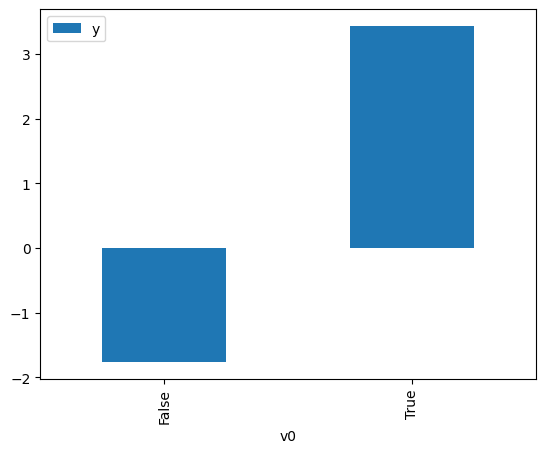

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

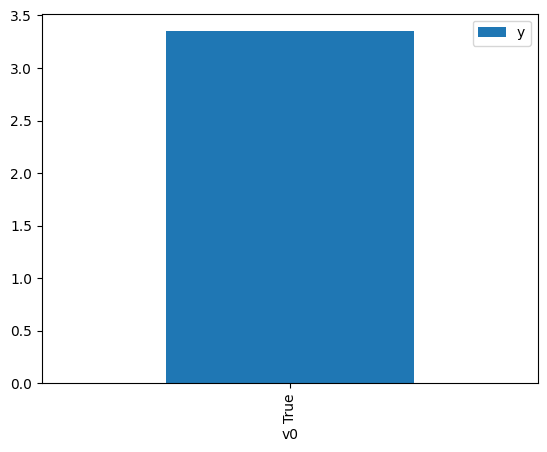

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.759866,False,-2.350318,0.951203,1.051300
1,-3.705130,False,-7.813499,0.998083,1.001920
2,-0.973429,False,-1.255691,0.837799,1.193603
3,0.218265,False,-0.253118,0.408403,2.448563
4,-0.332033,False,-1.476009,0.636166,1.571916
...,...,...,...,...,...
995,0.166965,False,-0.419433,0.429489,2.328350
996,-0.992005,False,-3.588534,0.842017,1.187624
997,-1.459873,False,-3.009158,0.921539,1.085141
998,-1.169292,False,-2.088625,0.877902,1.139079


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.755504,True,6.365941,0.782084,1.278635
1,0.479045,True,5.289250,0.692317,1.444425
2,-0.380484,True,4.133301,0.345114,2.897595
3,-1.065471,True,4.594604,0.142170,7.033826
4,0.479045,True,5.289250,0.692317,1.444425
...,...,...,...,...,...
995,-1.332082,True,4.402306,0.095554,10.465275
996,-0.778026,True,3.073351,0.212161,4.713404
997,-2.635462,True,-0.007357,0.011558,86.520595
998,-0.625354,True,4.370008,0.258435,3.869445


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              6458.
Date:                Fri, 25 Oct 2024   Prob (F-statistic):                        0.00
Time:                        14:44:17   Log-Likelihood:                         -1393.1
No. Observations:                1000   AIC:                                      2790.
Df Residuals:                     998   BIC:                                      2800.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7154      0.022     78.441      0.000       1.672       1.758
x2             4.9826      0.060     82.359      0.000       4.864       5.101
==============================================================================
Omnibus:                        0.921   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.631   Jarque-Bera (JB):                0.805
Skew:                           0.058   Prob(JB):                        0.669
Kurtosis:                       3.075   Cond. No.                         2.77
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""